# CGroup and CPUset

This notebook demonstrates the workload behaviour for cgroup and cpuset in EAS workshop

In [56]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)
from conf import LisaLogging
LisaLogging.setup()

2017-07-18 17:53:04,791 INFO    : root         : Using LISA logging configuration:
2017-07-18 17:53:04,796 INFO    : root         :   /media/build/workspace/lisa/logging.conf


In [76]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace
# from trace_analysis import TraceAnalysis

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Test environment setup

In [58]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    'ANDROID_HOME' : '/media/build/workspace/android-sdk',

    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.74',
    "username"    : 'root',
    "password"    : '',


    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }


}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],

            
    # List of additional devlib modules to install 
    "modules" : ['cgroups', 'bl', 'cpufreq'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "eas_cgroup_cpuset",
}

In [59]:
# Support to access the remote target
# import devlib
# from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf, force_new=True)
target = te.target
# Report target connection
logging.info('Connected to %s target', target.abi)
print "DONE"

2017-07-18 17:53:08,741 INFO    : TestEnv      : Using base path: /media/build/workspace/lisa
2017-07-18 17:53:08,745 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-07-18 17:53:08,746 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-07-18 17:53:08,748 INFO    : TestEnv      : External tools using:
2017-07-18 17:53:08,756 INFO    : TestEnv      :    ANDROID_HOME: /media/build/workspace/android-sdk
2017-07-18 17:53:08,757 INFO    : TestEnv      :    CATAPULT_HOME: /media/build/workspace/lisa/tools/catapult
2017-07-18 17:53:08,758 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'cgroups', 'hwmon']
2017-07-18 17:53:08,760 INFO    : TestEnv      : Connecting Android target [10.169.36.74:5555]
2017-07-18 17:53:08,761 INFO    : TestEnv      : Connection settings:
2017-07-18 17:53:08,762 INFO    : TestEnv      :    {'device': '10.169.36.74:5555'}


adb connect 10.169.36.74:5555


2017-07-18 17:53:11,646 INFO    : TestEnv      : Initializing target workdir:
2017-07-18 17:53:11,649 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-07-18 17:53:12,829 INFO    : CGroups      : Available controllers:
2017-07-18 17:53:13,065 INFO    : CGroups      :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh4
2017-07-18 17:53:13,293 INFO    : CGroups      :   cpu          : /data/local/tmp/devlib-target/cgroups/devlib_cgh3
2017-07-18 17:53:13,603 INFO    : CGroups      :   cpuacct      : /data/local/tmp/devlib-target/cgroups/devlib_cgh1
2017-07-18 17:53:13,831 INFO    : CGroups      :   schedtune    : /data/local/tmp/devlib-target/cgroups/devlib_cgh2
2017-07-18 17:53:14,055 INFO    : CGroups      :   freezer      : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
2017-07-18 17:53:14,284 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
2017-07-18 17:53:16,330 INFO    : TestEnv      : Topology:
2017-07-18 17

DONE


# Workload configuration

In [60]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',    
    
    # 2. define the "profile" of each task
    params={
        'task_p1': Periodic(
            period_ms=100,          # period
            duty_cycle_pct=10,      # duty cycle
            duration_s=10,           # duration    
            cpus="0",
        ).get(),
        'task_p2': Periodic(
            period_ms=100,          # period
            duty_cycle_pct=10,      # duty cycle
            duration_s=10,          # duration    
            cpus=str(target.bl.bigs[0]),    # "1"
        ).get(),
        'task_r1': Ramp(
            start_pct=10,           # intial load
            end_pct=30,             # end load
            delta_pct=5,            # load % increase...
            time_s=1,               # ... every 1[s]
            cpus="2",
        ).get(),
        'task_r2': Ramp(
            start_pct=10,           # intial load
            end_pct=30,             # end load
            delta_pct=5,            # load % increase...
            time_s=1,               # ... every 1[s]
            cpus="3"
        ).get(),
    },    
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2017-07-18 17:53:23,768 INFO    : Workload     : Setup new workload simple
2017-07-18 17:53:23,850 INFO    : Workload     : Workload duration defined by longest task
2017-07-18 17:53:23,853 INFO    : Workload     : Default policy: SCHED_OTHER
2017-07-18 17:53:23,856 INFO    : Workload     : ------------------------
2017-07-18 17:53:23,859 INFO    : Workload     : task [task_p1], sched: using default policy
2017-07-18 17:53:23,860 INFO    : Workload     :  | calibration CPU: 1
2017-07-18 17:53:23,861 INFO    : Workload     :  | loops count: 1
2017-07-18 17:53:23,864 INFO    : Workload     :  | CPUs affinity: 0
2017-07-18 17:53:23,865 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (100 loops)
2017-07-18 17:53:23,866 INFO    : Workload     : |  period   100000 [us], duty_cycle  10 %
2017-07-18 17:53:23,869 INFO    : Workload     : |  run_time  10000 [us], sleep_time  90000 [us]
2017-07-18 17:53:23,870 INFO    : Workload     : ------------------------
2017-07-18 17:53:23,8

# CPU governor setting

In [61]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('sched')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_cur_freq")
             )

2017-07-18 17:53:26,177 INFO    : root         : Target ABI: arm64, CPus: ['A53', 'A72', 'A72', 'A53', 'A53', 'A53']
2017-07-18 17:53:26,326 INFO    : root         : Target current governor: sched
2017-07-18 17:53:26,428 INFO    : root         : Target big CPU max CPUfreq:950000
		    Target big CPU current CPUfreq: 950000
2017-07-18 17:53:26,556 INFO    : root         : Target LITTLE CPU max CPUfreq:1200000 
		    Target LITTLE CPU current CPUfreq: 600000


# CGroup configuration

In [62]:
# create cgroup
target.execute("mount -t tmpfs cgroup_root /sys/fs/cgroup")
target.execute("mkdir /sys/fs/cgroup/devlib_cpu")
target.execute("mount -t cgroup -ocpu none /sys/fs/cgroup/devlib_cpu")
target.execute("cd /sys/fs/cgroup/devlib_cpu")

target.execute("mkdir /sys/fs/cgroup/devlib_cpu/high_load")    # create high_load group of tasks
target.execute("mkdir /sys/fs/cgroup/devlib_cpu/low_load")    # create low_load group of tasks

target.execute("echo 4096 > /sys/fs/cgroup/devlib_cpu/high_load/cpu.shares")
target.execute("echo 1024 > /sys/fs/cgroup/devlib_cpu/low_load/cpu.shares")

logging.info("High load:%s \n\t\t    Low load: %s", 
             target.read_value("/sys/fs/cgroup/devlib_cpu/high_load/cpu.shares"),
             target.read_value("/sys/fs/cgroup/devlib_cpu/low_load/cpu.shares")
             )

TargetError: Got exit code 1
from target command: mkdir /sys/fs/cgroup/devlib_cpu/high_load
STDOUT: 
STDERR: mkdir: '/sys/fs/cgroup/devlib_cpu/high_load': File exists


# Workload Execution Round: high_load CGroup

In [68]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="high_load")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2017-07-18 18:04:25,641 INFO    : root         : #### Setup FTrace
2017-07-18 18:04:27,781 INFO    : root         : #### Start energy sampling
2017-07-18 18:04:27,903 INFO    : root         : #### Start RTApp execution
2017-07-18 18:04:27,904 INFO    : Workload     : Workload execution START:
2017-07-18 18:04:27,905 INFO    : Workload     :    CGMOUNT=/data/local/tmp/devlib-target/cgroups /data/local/tmp/bin/shutils cgroups_run_into high_load /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
2017-07-18 18:04:39,137 INFO    : root         : #### Read energy consumption: /media/build/workspace/lisa/results/eas_cgroup_cpuset/energy.json
2017-07-18 18:04:39,252 INFO    : root         : #### Stop FTrace
2017-07-18 18:04:39,486 INFO    : root         : #### Save FTrace: /media/build/workspace/lisa/results/eas_cgroup_cpuset/trace.dat
2017-07-18 18:04:41,492 INFO    : root         : #### Save platform description: /media/build/workspace/lisa/results/eas_cgroup_cpuset

# Collected results

In [69]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
#!ls -la {te.res_dir}

2017-07-18 18:05:00,004 INFO    : root         : Content of the output folder /media/build/workspace/lisa/results/eas_cgroup_cpuset


In [70]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

2017-07-18 18:05:01,214 INFO    : root         : Generated RTApp JSON file:


In [71]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels , indent=4, sort_keys=True)

2017-07-18 18:05:03,683 INFO    : root         : Energy: /media/build/workspace/lisa/results/eas_cgroup_cpuset/energy.json


{
    "LITTLE": 1.9505550000000085, 
    "big": 3.2979880000000037
}


In [72]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

2017-07-18 18:05:07,946 INFO    : root         : Platform description: /media/build/workspace/lisa/results/eas_cgroup_cpuset/platform.json


# Trace inspection

In [73]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# New Task Behavior

In [74]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['task_p1',  "task_p2",
                                             "task_r1",  "task_r2", 
                                            ])

2017-07-18 18:05:23,219 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2017-07-18 18:11:46,871 INFO    : PerfAnalysis : PerfIndex, Task [task_r2] avg: 0.11, std: 0.37
2017-07-18 18:11:48,559 INFO    : PerfAnalysis : PerfIndex, Task [task_r1] avg: 0.72, std: 0.11
2017-07-18 18:11:50,195 INFO    : PerfAnalysis : PerfIndex, Task [task_p1] avg: 0.61, std: 0.02
2017-07-18 18:11:51,828 INFO    : PerfAnalysis : PerfIndex, Task [task_r20] avg: -25.95, std: 45.59
2017-07-18 18:11:53,118 INFO    : PerfAnalysis : PerfIndex, Task [task_p2] avg: 0.86, std: 0.01


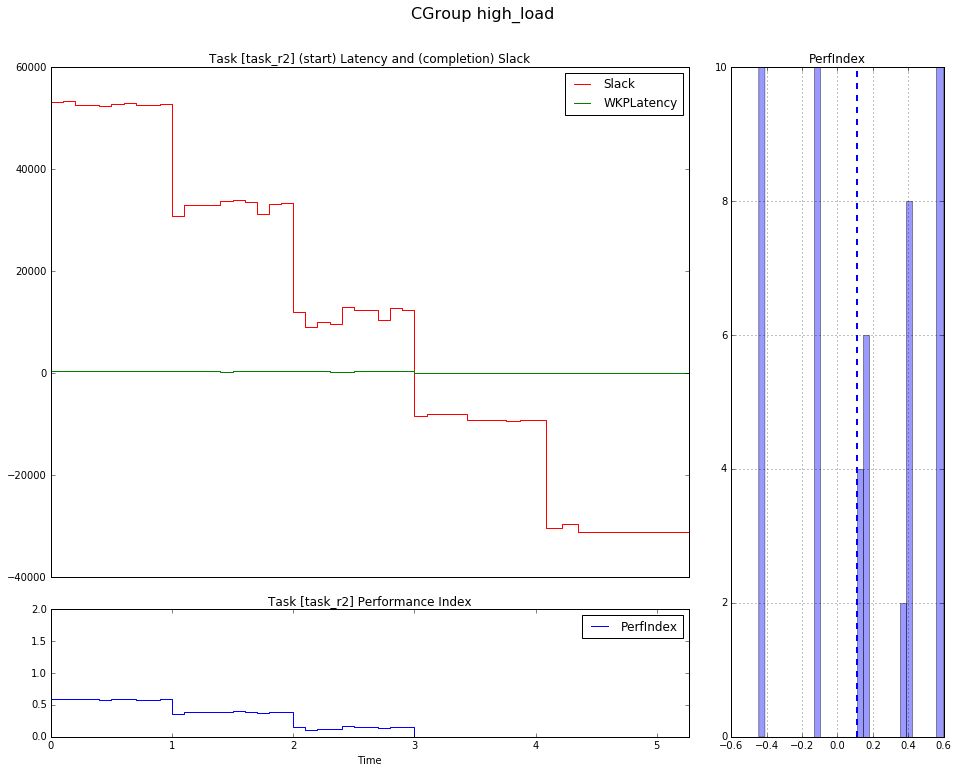

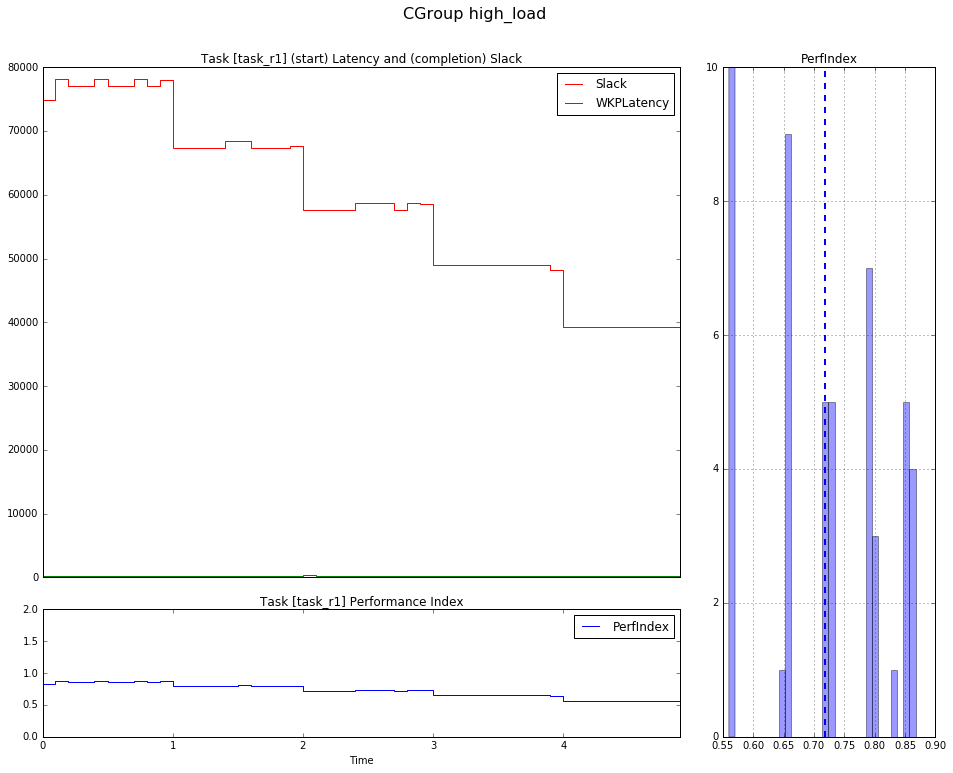

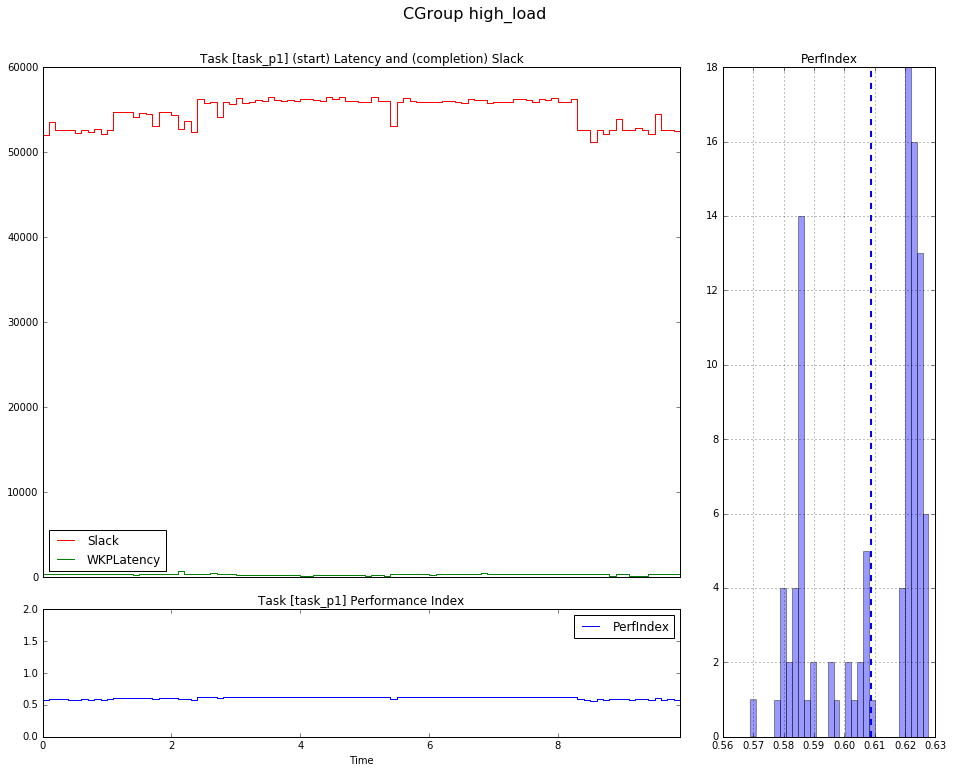

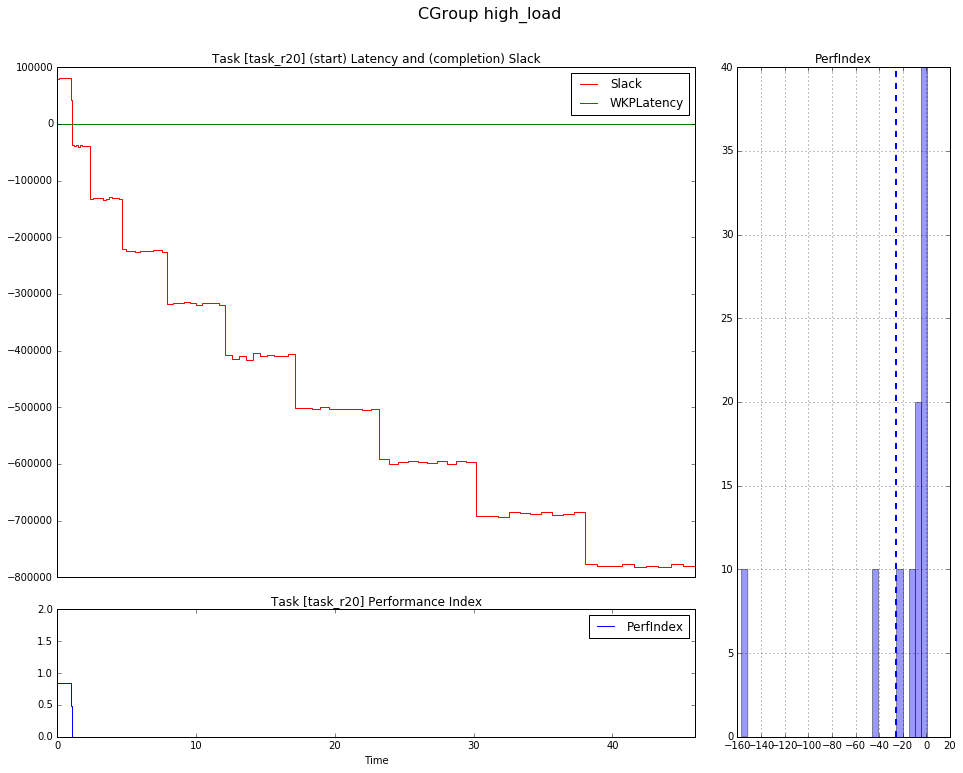

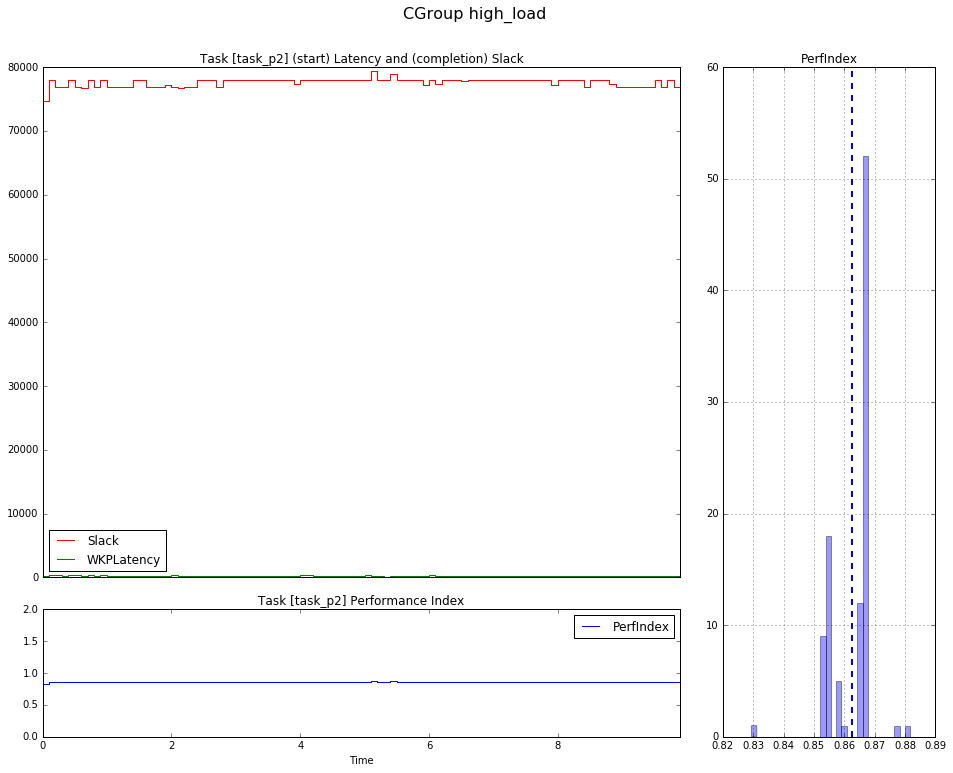

In [77]:
pa = PerfAnalysis( te.res_dir )

for task in pa.tasks():
    pa.plotPerf(task, "CGroup high_load")

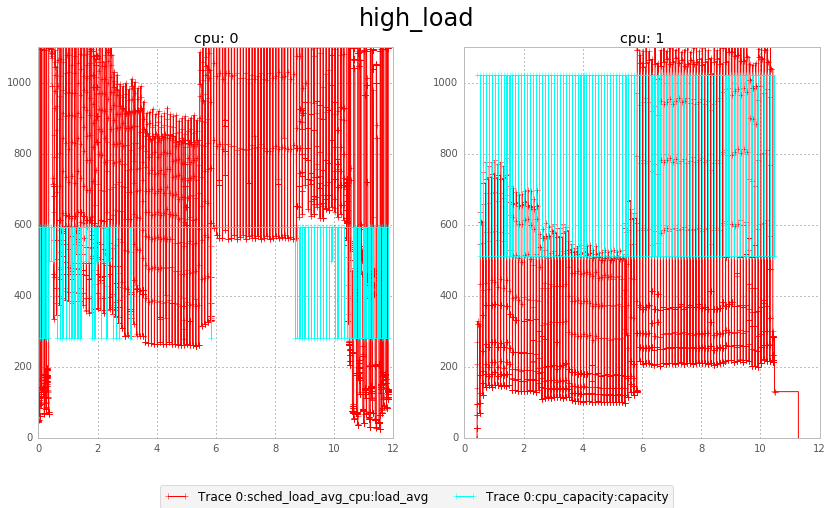

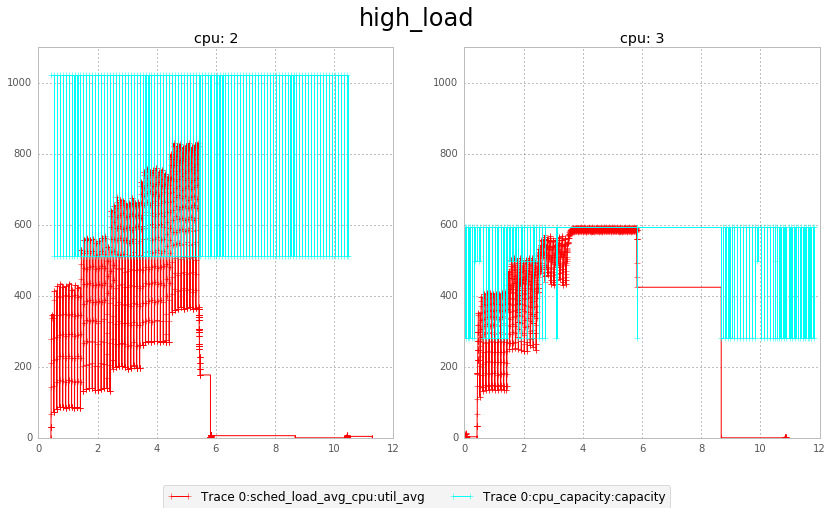

In [78]:
trappy.LinePlot(ftrace,
    signals=[
    #"sched_load_avg_cpu:util_avg",
    "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [0,1]},
    marker = '+',
    drawstyle='steps-post',
    title="high_load",
    ylim=(0, 1100)).view()

trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [2,3]},
    marker = '+',
    drawstyle='steps-post',
    title="high_load",
    ylim=(0, 1100)).view()

# Workload Execution Round: low_load cgroup

In [80]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="low_load")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2017-07-18 18:13:45,116 INFO    : root         : #### Setup FTrace
2017-07-18 18:13:46,327 INFO    : root         : #### Start energy sampling
2017-07-18 18:13:46,471 INFO    : root         : #### Start RTApp execution
2017-07-18 18:13:46,480 INFO    : Workload     : Workload execution START:
2017-07-18 18:13:46,486 INFO    : Workload     :    CGMOUNT=/data/local/tmp/devlib-target/cgroups /data/local/tmp/bin/shutils cgroups_run_into low_load /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
2017-07-18 18:13:57,739 INFO    : root         : #### Read energy consumption: /media/build/workspace/lisa/results/eas_cgroup_cpuset/energy.json
2017-07-18 18:13:57,857 INFO    : root         : #### Stop FTrace
2017-07-18 18:13:58,127 INFO    : root         : #### Save FTrace: /media/build/workspace/lisa/results/eas_cgroup_cpuset/trace.dat
2017-07-18 18:14:00,042 INFO    : root         : #### Save platform description: /media/build/workspace/lisa/results/eas_cgroup_cpuset/

In [82]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2017-07-18 18:14:48,762 INFO    : root         : Energy: /media/build/workspace/lisa/results/eas_cgroup_cpuset/energy.json


{
    "LITTLE": 1.9585579999999823, 
    "big": 3.3036690000000135
}


# Trace Inspection

In [83]:
trappy.plotter.plot_trace(te.res_dir)

In [84]:
events_to_parse = my_tests_conf['ftrace']['events']

trace_low = Trace(plt, te.res_dir, events_to_parse)

ftrace_low = trace_low.ftrace

trappy.plotter.plot_trace(ftrace_low, execnames=['task_p1',  "task_p2",
                                             "task_r1",  "task_r2", 
                                            ])

2017-07-18 18:15:02,015 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2017-07-18 18:15:19,596 INFO    : PerfAnalysis : PerfIndex, Task [task_r2] avg: 0.11, std: 0.36
2017-07-18 18:15:21,101 INFO    : PerfAnalysis : PerfIndex, Task [task_r1] avg: 0.72, std: 0.10
2017-07-18 18:15:22,607 INFO    : PerfAnalysis : PerfIndex, Task [task_p1] avg: 0.60, std: 0.02
2017-07-18 18:15:24,095 INFO    : PerfAnalysis : PerfIndex, Task [task_r20] avg: -25.95, std: 45.59
2017-07-18 18:15:25,298 INFO    : PerfAnalysis : PerfIndex, Task [task_p2] avg: 0.86, std: 0.01


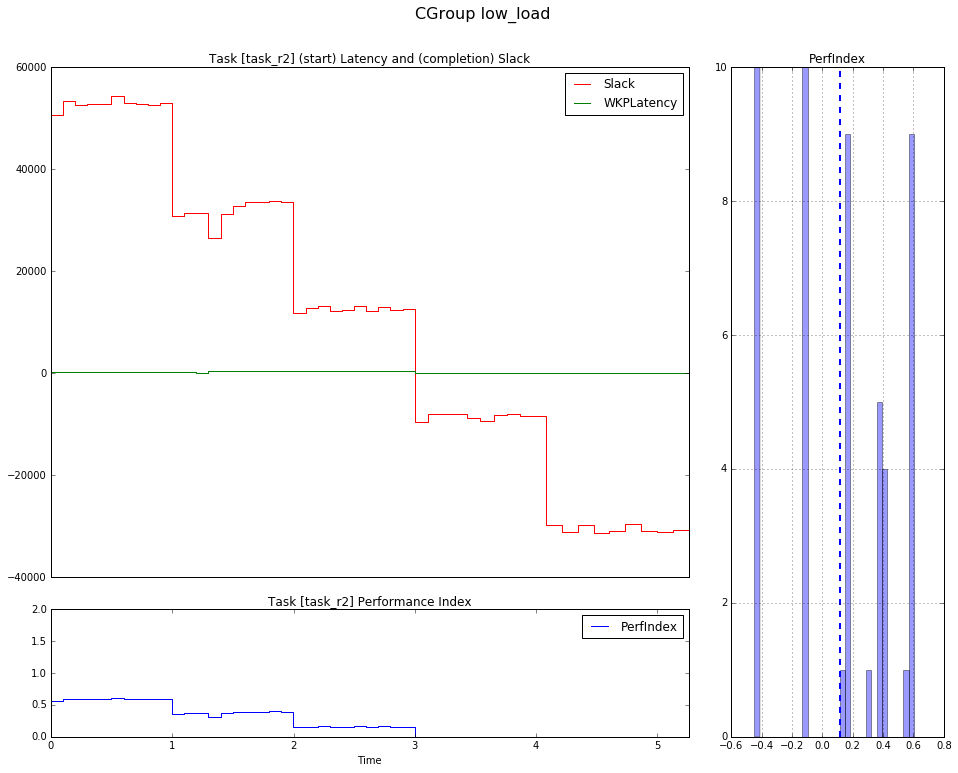

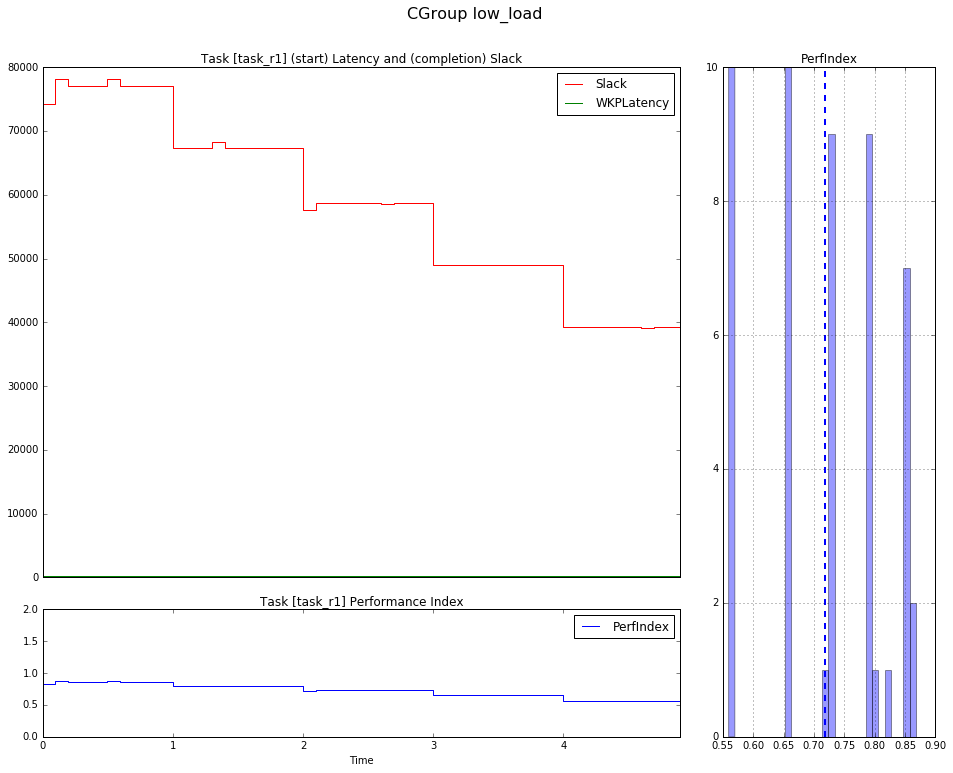

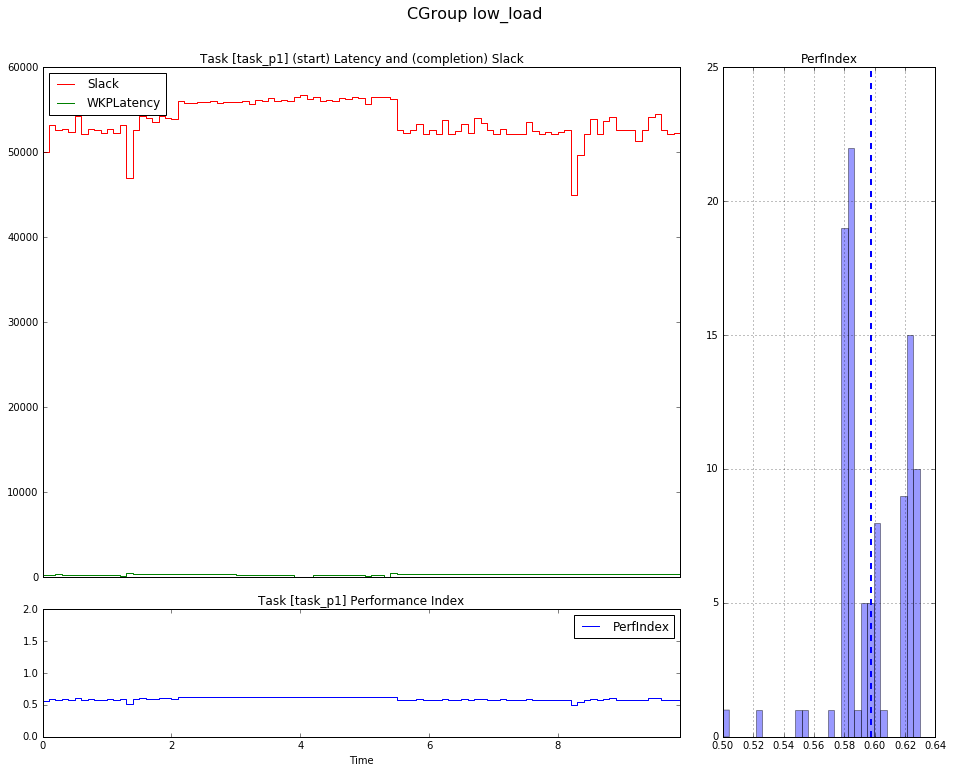

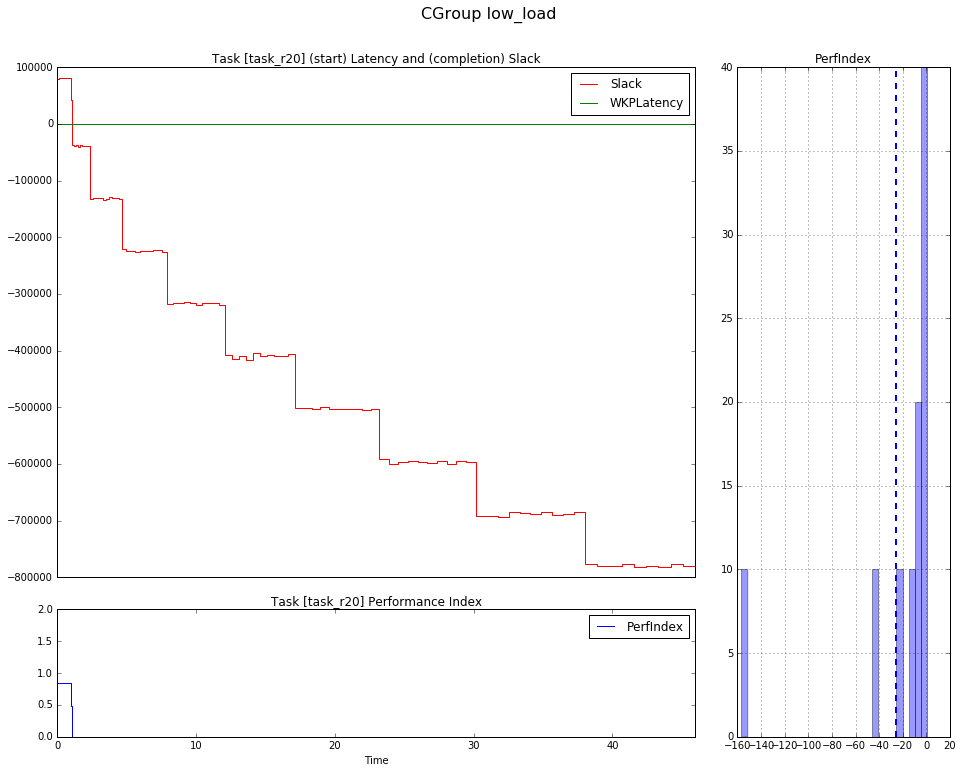

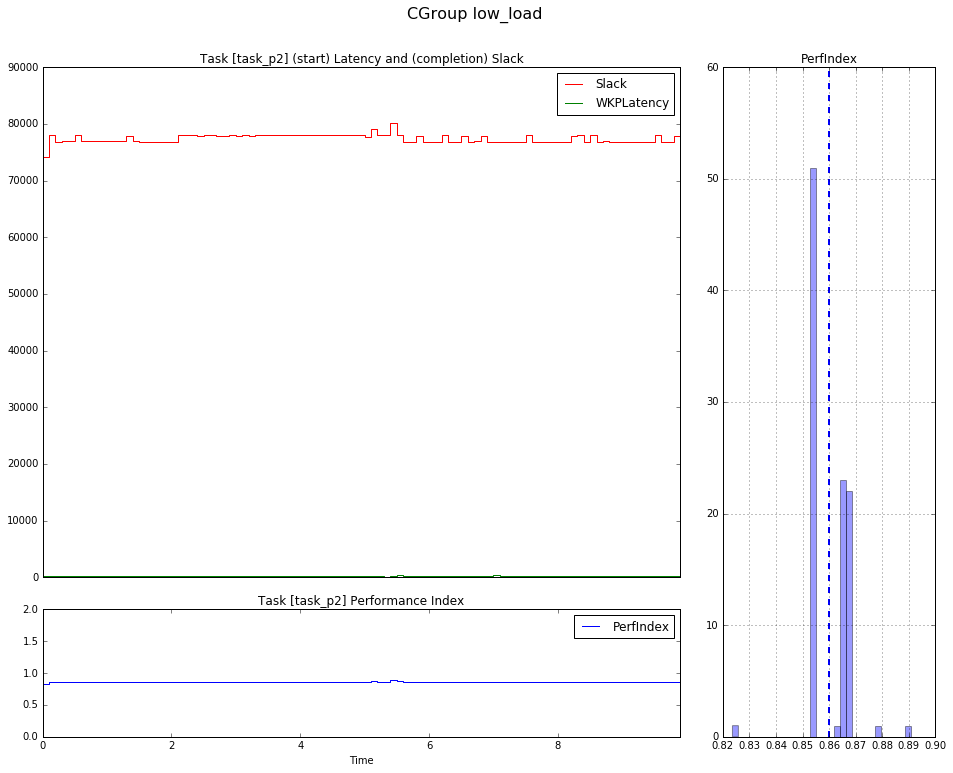

In [85]:
pa_low = PerfAnalysis( te.res_dir )

for task in pa_low.tasks():
    pa_low.plotPerf(task, "CGroup low_load")

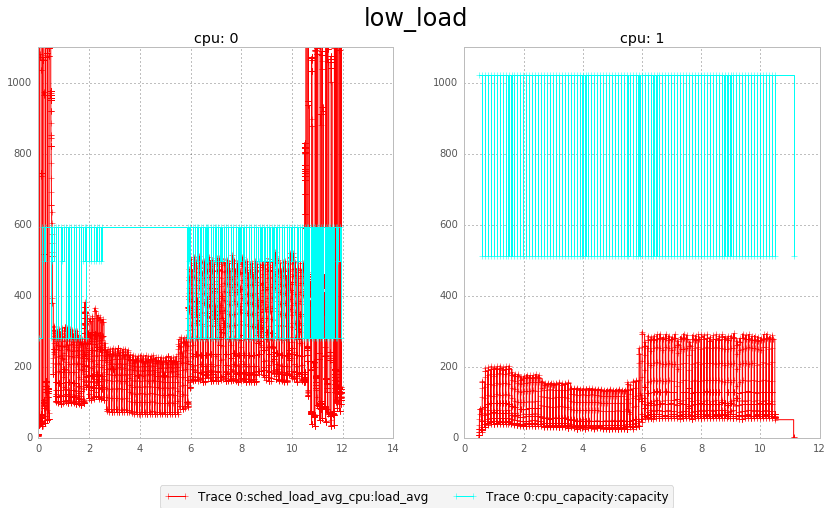

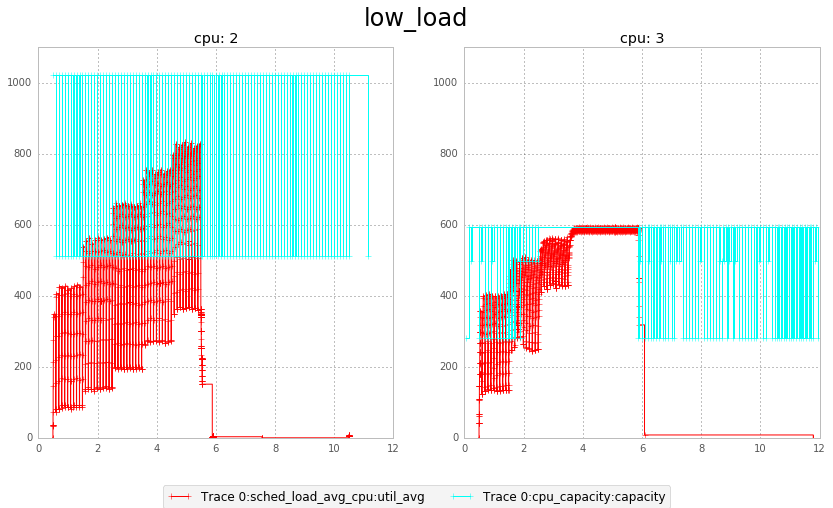

In [86]:
trappy.LinePlot(ftrace_low,
    signals=[
   # "sched_load_avg_cpu:util_avg",
    "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [0,1]},
    marker = '+',
    drawstyle='steps-post',
    title="low_load",
    ylim=(0, 1100)).view()

trappy.LinePlot(ftrace_low,
    signals=[
    "sched_load_avg_cpu:util_avg",
   # "sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"
    ],
    pivot="cpu",
    filters={"cpu": [2,3]},
    marker = '+',
    drawstyle='steps-post',
    title="low_load",
    ylim=(0, 1100)).view()